In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/storage/ducpm/lung-segmentation


In [2]:
import time
import glob
from pathlib import Path
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import SimpleITK as sitk
import pydicom
import nibabel as nib

import torch
from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from src.data import * 
from src.utils import profile_load_time
from src.visualization import plot_batch
from src.preprocess import Clip, Normalize, ToTensor 

In [3]:
#ds = NSCLCDataset(ct_dir="data/raw/NSCLC-Radiomics/",
#                  mask_dir="data/processed/NSCLC_ground_truths/",
#                  ct_ids=["LUNG1-001", "LUNG1-002"],
#                  transform=DEFAULT_TRANSFORM)

In [4]:
# new subsetting strat
#df = pd.read_csv("data/processed/NSCLC-Radiomics_metadata.csv")
#
#df["ct_id"] = df["mask_path"].apply(lambda path: path.split("/")[-2])
#df.head()
#df.to_csv("data/processed/NSCLC-Radiomics_metadata_v2.csv", index=False)

In [5]:
transform = transforms.Compose([
    Clip(-1000, 1000),
    ToTensor(),
    Normalize(mean=[0.0], std=[1000.0]),
])

ct_ids = get_common_ids("data/raw/NSCLC-Radiomics/", "data/processed/NSCLC_ground_truths/") 
train_ratio = 0.7
val_ratio = 0.2

num_train_scans = int(len(ct_ids) * train_ratio)
num_val_scans = int(len(ct_ids) * val_ratio)

train_scans = ct_ids[:num_train_scans]
val_scans = ct_ids[num_train_scans:num_train_scans+num_val_scans]
test_scans = ct_ids[num_train_scans+num_val_scans:]

train_ds = NSCLCDataset( metadata_path="data/processed/NSCLC-Radiomics_metadata_v2.csv", transform=transform, ct_ids=train_scans)
val_ds = NSCLCDataset( metadata_path="data/processed/NSCLC-Radiomics_metadata_v2.csv", transform=transform, ct_ids=val_scans)

train_loader = DataLoader( train_ds, batch_size=16, collate_fn=simple_collate_fn, num_workers=4, shuffle=True)
val_loader = DataLoader( val_ds, batch_size=16, collate_fn=simple_collate_fn, num_workers=4, shuffle=True)

In [6]:
len(train_ds), len(val_ds)

(26267, 13516)

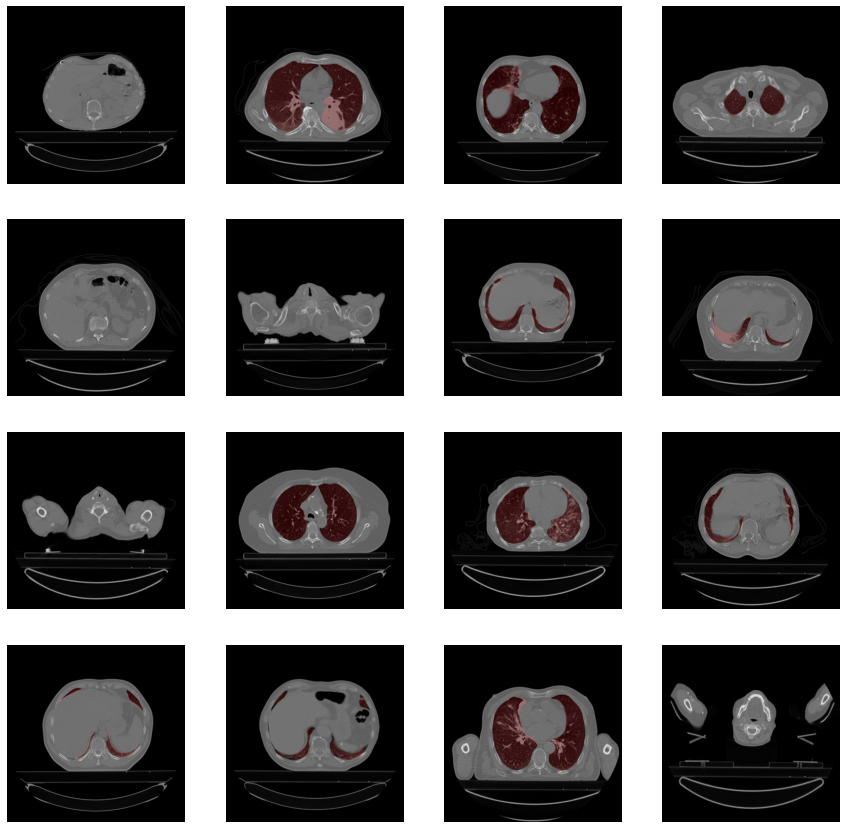

In [7]:
X_batch, y_batch = next(iter(train_loader))
plot_batch(X_batch, y_batch, nrows=4, ncols=4)